In [1]:
#pip install gymnasium
#pip install swig
#pip install gymnasium[box2d]

In [1]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from collections import deque
import random
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from google.colab import files

In [2]:
# If there's a GPU available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU is not available")


GPU is available


In [3]:
torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.get_device_name(0)

'Tesla T4'

In [4]:
!nvidia-smi

Tue Jul  2 10:27:33 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8              10W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
torch.cuda.empty_cache()

## DQN

In [9]:
class DQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, action_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class DQNAgent:
    def __init__(self, state_dim, action_dim):
        self.model = DQN(state_dim, action_dim).to(device)
        self.target_model = DQN(state_dim, action_dim).to(device)
        self.update_target_model()
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.001)
        self.epsilon = 1.00
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.99
        self.gamma = 0.99
        self.memory = deque(maxlen=10000)
        self.batch_size = 64

    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.choice(env.action_space.n)
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        q_values = self.model(state)
        return torch.argmax(q_values, dim=1).item()

    def replay(self):
        if len(self.memory) < self.batch_size:
            return
        batch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        states = torch.FloatTensor(states).to(device)
        actions = torch.LongTensor(actions).to(device)
        rewards = torch.FloatTensor(rewards).to(device)
        next_states = torch.FloatTensor(next_states).to(device)
        dones = torch.FloatTensor(dones).to(device)

        current_q = self.model(states).gather(1, actions.unsqueeze(1)).squeeze(1)
        next_q = self.target_model(next_states).max(1)[0]
        target_q = rewards + self.gamma * next_q * (1 - dones)

        loss = torch.nn.functional.mse_loss(current_q, target_q.detach())
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()


    def save_model(self, path):
        torch.save(self.model.state_dict(), path)

    def load_model(self, path):
        self.model.load_state_dict(torch.load(path))
        self.update_target_model()

In [10]:
def train_dqn_agent(env, agent, episodes=4000):
    rewards = []
    for e in range(episodes):
        state = env.reset()
        total_reward = 0
        for time in range(500):
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward
            if done:
                print(f"episode: {e+1}/{episodes}, score: {total_reward}, eps: {agent.epsilon:.2}")
                break
            agent.replay()
        if agent.epsilon > agent.epsilon_min or e>=2500:
            agent.epsilon *= agent.epsilon_decay
        rewards.append(total_reward)
        if e % 10 == 0:
            agent.update_target_model()
    return rewards

In [ ]:
env = gym.make('LunarLander-v2')
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
dqn_agent = DQNAgent(state_dim, action_dim)
dqn_rewards = train_dqn_agent(env, dqn_agent)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


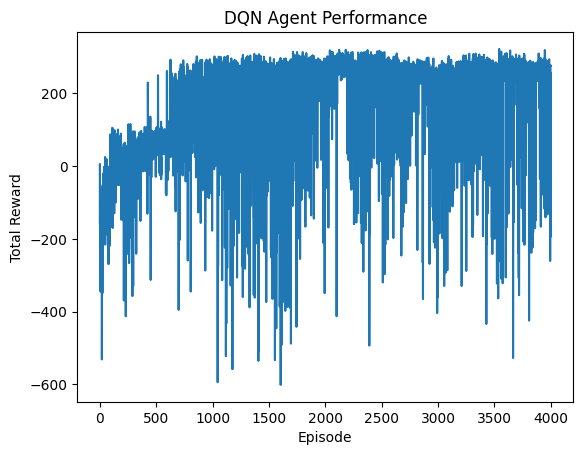

In [12]:
plt.plot(dqn_rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('DQN Agent Performance')
plt.show()

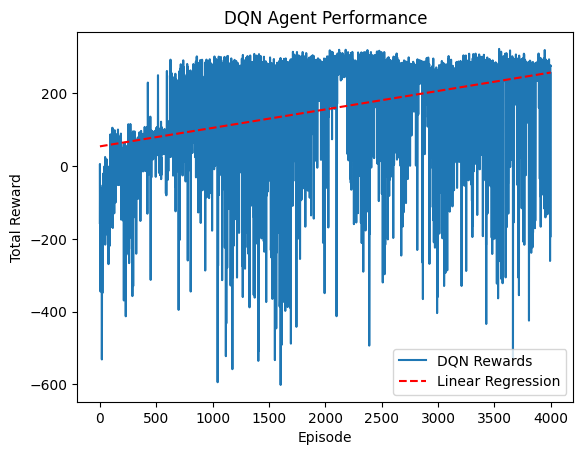

In [ ]:
lenx = [[i+1] for i in range(len(dqn_rewards))]
dqn_rewards2 = [[reward] for reward in dqn_rewards]

lin_reg_dqn = LinearRegression()
lin_reg_dqn.fit(lenx, dqn_rewards2)

predicted_rewards = lin_reg_dqn.predict(lenx)

plt.plot([reward[0] for reward in dqn_rewards2], label='DQN Rewards')
plt.plot([x[0] for x in lenx], [reward[0] for reward in predicted_rewards], linestyle='dashed', color='r', label='Linear Regression')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('DQN Agent Performance')
plt.legend()
plt.show()

### Saving & loading the DQN model (agent) for future using

In [38]:
dqn_agent.save_model('dqn_model.pth')

In [39]:
# Download the saved model to your local machine
files.download('dqn_model.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Load the model
env = gym.make('LunarLander-v2')
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
loaded_dqn_agent = DQNAgent(state_dim, action_dim)
loaded_dqn_agent.epsilon = 0.00
loaded_dqn_agent.load_model('dqn_model.pth')

In [58]:
new_dqn_rewards = train_dqn_agent(env,loaded_dqn_agent, episodes=100)

/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


episode: 1/100, score: 279.914611685768, eps: 0.0
episode: 3/100, score: 257.89231084159644, eps: 0.0
episode: 4/100, score: 271.46026492895686, eps: 0.0
episode: 6/100, score: 271.6769332577245, eps: 0.0
episode: 7/100, score: 245.20363100933014, eps: 0.0
episode: 8/100, score: 281.68600768276985, eps: 0.0
episode: 9/100, score: 252.27009807118984, eps: 0.0
episode: 11/100, score: 263.6425391609403, eps: 0.0
episode: 13/100, score: -23.17296604589403, eps: 0.0
episode: 14/100, score: -277.0398626462381, eps: 0.0
episode: 16/100, score: 236.89878831138668, eps: 0.0
episode: 17/100, score: -77.76275114142541, eps: 0.0
episode: 18/100, score: 262.32148276003875, eps: 0.0
episode: 19/100, score: 287.444122958703, eps: 0.0
episode: 21/100, score: 264.69417333982005, eps: 0.0
episode: 22/100, score: -316.07524539521995, eps: 0.0
episode: 23/100, score: 260.2800875698268, eps: 0.0
episode: 24/100, score: 284.1601262403793, eps: 0.0
episode: 25/100, score: 24.28710176046843, eps: 0.0
episode:

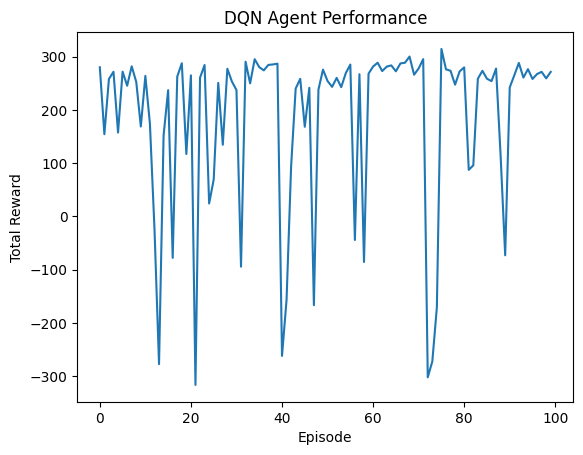

In [59]:
plt.plot(new_dqn_rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('DQN Agent Performance')
plt.show()

In [84]:
torch.cuda.empty_cache()

## Actor Critic

In [85]:
class ActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(ActorCritic, self).__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, 128)

        self.actor = nn.Linear(128, action_dim)
        self.critic = nn.Linear(128, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.actor(x), self.critic(x)

class ActorCriticAgent:
    def __init__(self, state_dim, action_dim):
        self.model = ActorCritic(state_dim, action_dim)
        self.saved_model = ActorCritic(state_dim, action_dim)
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.001)
        self.gamma = 0.99

    def select_action(self, state):
        state = torch.FloatTensor(state).unsqueeze(0)
        logits, _ = self.model(state)
        probs = torch.softmax(logits, dim=-1)
        action = np.random.choice(np.arange(probs.shape[-1]), p=probs.detach().numpy().flatten())
        return action, probs

    def update(self, trajectory):
        states, actions, rewards, next_states, dones = zip(*trajectory)
        rewards = (rewards - np.mean(rewards)) / (np.std(rewards))
        states = torch.FloatTensor(states)
        actions = torch.LongTensor(actions)
        rewards = torch.FloatTensor(rewards)
        next_states = torch.FloatTensor(next_states)
        dones = torch.FloatTensor(dones)

        logits, values = self.model(states)
        _, next_values = self.model(next_states)

        values = values.squeeze(1)
        next_values = next_values.squeeze(1)

        targets = rewards + self.gamma * next_values * (1 - dones)
        advantage = targets - values

        log_probs = torch.log_softmax(logits, dim=-1)
        selected_log_probs = log_probs[np.arange(len(actions)), actions]

        actor_loss = -torch.mean(selected_log_probs * advantage.detach())
        critic_loss = torch.mean(advantage ** 2)

        loss = actor_loss + critic_loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def update_model(self):
        self.saved_model.load_state_dict(self.model.state_dict())

    def save_model(self, path):
        torch.save(self.model.state_dict(), path)

    def load_model(self, path):
        self.model.load_state_dict(torch.load(path))
        self.update_model()

In [86]:
def train_actor_critic_agent(env,agent, episodes=4000):
    rewards = []
    for e in range(episodes):
        state = env.reset()
        total_reward = 0
        trajectory = []
        for time in range(500):
            action, _ = agent.select_action(state)
            next_state, reward, done, _ = env.step(action)
            trajectory.append((state, action, reward, next_state, done))
            state = next_state
            total_reward += reward
            if done:
                print(f"episode: {e+1}/{episodes}, score: {total_reward}")
                break
        rewards.append(total_reward)
        agent.update(trajectory)
        if e % 1000 == 0:
            agent.update_model()
    return rewards

In [ ]:
env = gym.make('LunarLander-v2')
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
ac_agent = ActorCriticAgent(state_dim, action_dim)
ac_rewards = train_actor_critic_agent(env,ac_agent)

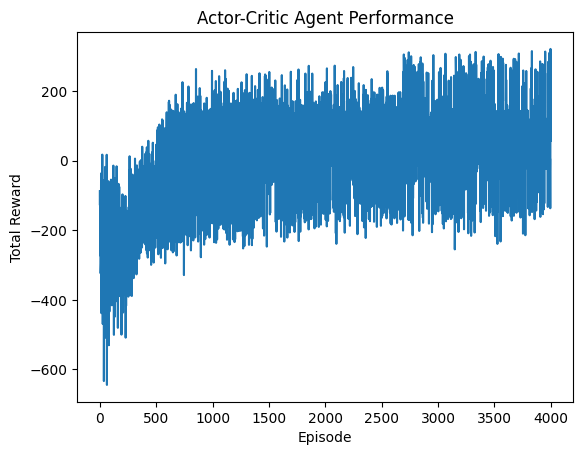

In [88]:
plt.plot(ac_rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Actor-Critic Agent Performance')
plt.show()

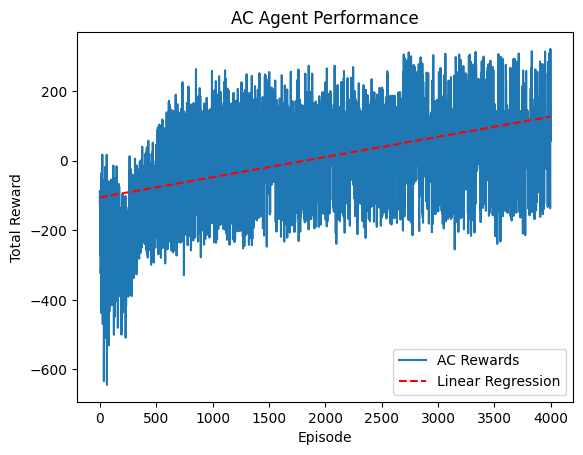

In [89]:
lenx = [[i+1] for i in range(len(ac_rewards))]
ac_rewards2 = [[reward] for reward in ac_rewards]

lin_reg_ac = LinearRegression()
lin_reg_ac.fit(lenx, ac_rewards2)

predicted_rewards = lin_reg_ac.predict(lenx)

plt.plot([reward[0] for reward in ac_rewards2], label='AC Rewards')
plt.plot([x[0] for x in lenx], [reward[0] for reward in predicted_rewards], linestyle='dashed', color='r', label='Linear Regression')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('AC Agent Performance')
plt.legend()
plt.show()

### Saving & loading the AC model (agent) for future using

In [90]:
ac_agent.save_model('ac_model.pth')

In [91]:
files.download('ac_model.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [92]:
# Load the model
env = gym.make('LunarLander-v2')
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
loaded_ac_agent = ActorCriticAgent(state_dim, action_dim)
loaded_ac_agent.load_model('ac_model.pth')

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [96]:
new_ac_rewards = train_actor_critic_agent(env,loaded_ac_agent, episodes=100)

episode: 1/100, score: 18.310072548010666
episode: 2/100, score: 61.06186611354519
episode: 3/100, score: 35.390018061466236
episode: 4/100, score: 17.031217078378617
episode: 6/100, score: -154.2888150793771
episode: 7/100, score: 280.225564010527
episode: 9/100, score: 259.92863677729855
episode: 11/100, score: 62.61403625447326
episode: 14/100, score: -152.61682764332306
episode: 23/100, score: -219.7492711857534
episode: 30/100, score: -127.4735180518398
episode: 33/100, score: -49.29503348439935
episode: 36/100, score: -23.26368046246219
episode: 38/100, score: 36.43692512254441
episode: 40/100, score: 239.73216707473435
episode: 41/100, score: -154.71899850797203
episode: 42/100, score: -48.776932255074975
episode: 43/100, score: -6.440505382753074
episode: 44/100, score: 247.80809753128068
episode: 46/100, score: 257.5953357886979
episode: 47/100, score: -8.956881885479874
episode: 49/100, score: 243.8929051831346
episode: 51/100, score: -2.6813375050902124
episode: 52/100, scor

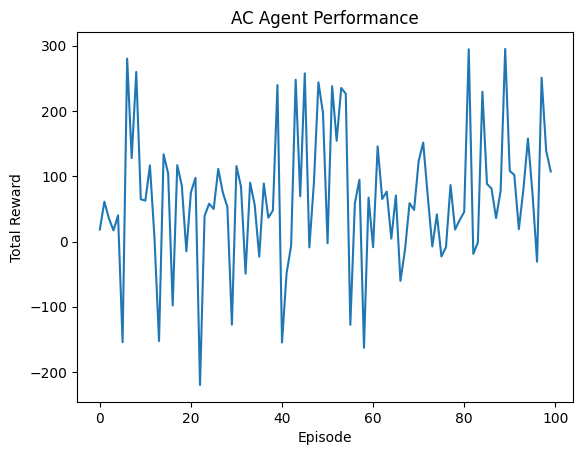

In [97]:
plt.plot(new_ac_rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('AC Agent Performance')
plt.show()

In [98]:
torch.cuda.empty_cache()

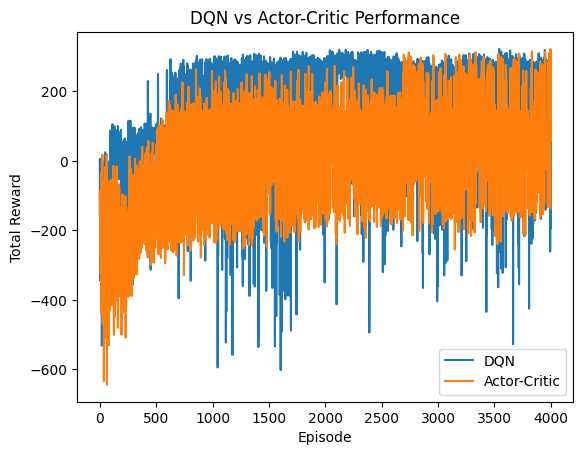

In [99]:
plt.plot(dqn_rewards, label='DQN')
plt.plot(ac_rewards, label='Actor-Critic')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('DQN vs Actor-Critic Performance')
plt.legend()
plt.show()

In [100]:
print("Average reward DQN: ",np.mean(dqn_rewards))
print("Average reward AC: ",np.mean(ac_rewards))

Average reward DQN:  155.62131433877755
Average reward AC:  10.79771538902315


In [101]:
print("STD reward DQN: ",np.std(dqn_rewards))
print("STD reward AC: ",np.std(ac_rewards))

STD reward DQN:  157.86203104989397
STD reward AC:  144.02760296095155


In [102]:
print("Maximum reward DQN: ",np.max(dqn_rewards))
print("Maximum reward AC: ",np.max(ac_rewards))

Maximum reward DQN:  321.9201109316391
Maximum reward AC:  321.4184822819325


In [103]:
print("Average reward at end DQN: ",np.mean(dqn_rewards[3500:]))
print("Average reward at end AC: ",np.mean(ac_rewards[3500:]))

Average reward at end DQN:  213.02550956783915
Average reward at end AC:  59.03260175342469


In [104]:
print("STD reward at end DQN: ",np.std(dqn_rewards[3500:]))
print("STD reward at end AC: ",np.std(ac_rewards[3500:]))

STD reward at end DQN:  141.3443642568047
STD reward at end AC:  107.27005905075819
